In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from numpy.polynomial import Polynomial

# The Particle Method and Smile Calibration
Consider the stochastic local volatility (SLV) model

$$
\begin{array}{l}
dS_t = a_t l(t, S_t) S_t dW^{(1)}_t\\
a_t=\sigma_0 e^{Y_t}\quad\text{where}\quad d Y_t = -\kappa Y_tdt+\gamma dW^{(2)}_t\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

The numerical values for the model parameters are
- $T = 1$.
- $S_0 = 100$.
- $\sigma_0 = 15\%$.
- $Y_0 = 0$.
- $\rho = -50\%$.
- $\gamma = 50\%$.
- $\kappa = 1$.

The goal is to find a leverage function $l(t, S)$ so that this model matches the market prices of vanilla options. For the sake of simplicity, we assume that the market implied volatility surface is flat $\sigma_{\textrm{Market}} \equiv 15\%$. In that case, we also have $\sigma_{\textrm{Dup}}(t,S) \equiv 15\%$.

Below we describe a Monte Carlo simulation scheme for the SLV model.

First we discretize the interval $(0,T)$ into subintervals $(t_{i-1}, t_i)$, $1\leq i\leq n$, and set $\Delta t_i=t_i-t_{i-1}$.

The Ornstein-Uhlenbeck process $Y$ is explicitly solvable:
\begin{equation}
Y_{t_i}=e^{-\kappa\Delta t_i}Y_{t_{i-1}}+\int_{t_{i-1}}^{t_i}\gamma e^{-\kappa\left(t_i-s\right)}dW_s^{(2)}.
\end{equation}

Therefore for given $Y_{t_{i-1}}$, $Y_{t_i}$ is a Gaussian variable with
\begin{equation}\tag{1}
\mathbb{E}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=e^{-\kappa\Delta t_i}Y_{t_{i-1}},\quad
\text{var}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=\frac{\gamma^2}{2\kappa}\left(1-e^{-2\kappa\Delta t_i}\right)
\end{equation}

so that paths of $Y$ can be simulated exactly.

To simualte the spot process $S$, we use the Euler scheme:
$$\log S_{t_i}-\log S_{t_{i-1}}=-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i+\sigma_0 e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\int_{t_{i-1}}^{t_i}dW^{(1)}_t$$

Thus for given $S_{t_{i-1}}$ and $Y_{t_{i-1}}$, $\log S_{t_i}$ and $Y_{t_i}$ are jointly Gaussian variables with

\begin{equation}\tag{2}
\mathbb{E}\left[\left.\log S_{t_i}\right\vert S_{t_{i-1}},Y_{t_{i-1}}\right]=\log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}\Delta t_i,\quad\text{Var}\left[\left.\log S_{t_i}\right\vert S_{i_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i
\end{equation}

\begin{equation}\tag{3}
\text{Cov}\left[\left.Y_{t_i},\log S_{t_i}\right\vert S_{t_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0 e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\frac{\gamma\rho}{\kappa}\left(1-e^{-\kappa\Delta t_i}\right)
\quad\text{or}\quad
\text{Corr}\left[\left.Y_{t_i},\log S_{t_i}\right\vert S_{t_{i-1}}, Y_{t_{i-1}}\right]=\rho\sqrt{\frac{2(1-e^{-\kappa\Delta t_i})}{\kappa\Delta t_i(1+e^{-\kappa\Delta t_i})}}
\end{equation}

Over the time interval $[t_{i-1}, t_i]$, we can advance $\log S$ and $Y$ by generating Gaussian variables $\log S_{t_i}$ and $Y_{t_i}$ using equations (1)-(3). That is,

\begin{align}
\log S_{t_i} &= \log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i+\sigma_0e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\sqrt{\Delta t_i}\left(\sqrt{1-\bar{\rho}^2}Z_1+\bar{\rho}Z_2\right),\quad\text{where }\bar{\rho}=\rho\sqrt{\frac{2(1-e^{-\kappa\Delta t_i})}{\kappa\Delta t_i(1+e^{-\kappa\Delta t_i})}}\\
Y_{t_i} &= e^{-\kappa\Delta t_i}Y_{t_{i-1}}+\gamma\sqrt{\frac{1-e^{-2\kappa\Delta t_i}}{2\kappa}}Z_2
\end{align}
where $Z_1$ and $Z_2$ are independent standard normal variables.

In [8]:
def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in Black-Scholes model

    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option.
    S: scalar or array_like
        The spot price of the underlying security.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S*np.exp((r-q)*T)
    w = vol**2*T
    d1 = (np.log(F/K)+0.5*w)/np.sqrt(w)
    d2 = d1 - np.sqrt(w)
    callput = callput.lower()
    if callput == 'call':
        opttype = 1
    elif callput == 'put':
        opttype = -1
    else:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = (opttype*F*norm.cdf(opttype*d1)-opttype*K*norm.cdf(opttype*(d2)))*np.exp(-r*T)
    return price

In [9]:
# all inputs must be scalar
def blackscholes_impv_scalar(K, T, S, value, r=0, q=0, callput='call', tol=1e-6, maxiter=500):
    """Compute implied vol in Black-Scholes model

    Parameters
    ----------
    K: scalar
        The strike of the option.
    T: scalar
        The maturity of the option.
    S: scalar
        The spot price of the underlying security.
    value: scalar
        The value of the option
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    vol: scalar
        The implied vol of the option.
    """
    if (K <= 0) or (T <= 0):
        return np.nan
    F = S*np.exp((r-q)*T)
    K = K/F
    value = value*np.exp(r*T)/F
    callput = callput.lower()
    if callput not in ['call', 'put']:
        raise ValueError('The value of "callput" must be either "call" or "put"')
    opttype = 1 if callput == 'call' else -1
    value -= max(opttype * (1 - K), 0)
    if value < 0:
        return np.nan
    if (value == 0):
        return 0
    j = 1
    p = np.log(K)
    if K >= 1:
        x0 = np.sqrt(2 * p)
        x1 = x0 - (0.5 - K * norm.cdf(-x0) - value) * np.sqrt(2*np.pi)
        while (abs(x0 - x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1 - (norm.cdf(d1) - K*norm.cdf(d1-x1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1 / np.sqrt(T)
    else:
        x0 = np.sqrt(-2 * p)
        x1 = x0 - (0.5*K-norm.cdf(-x0)-value)*np.sqrt(2*np.pi)/K
        while (abs(x0-x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1-(K*norm.cdf(x1-d1)-norm.cdf(-d1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1/np.sqrt(T)

# vectorized version
blackscholes_impv = np.vectorize(blackscholes_impv_scalar, excluded={'callput', 'tol', 'maxiter'})

# Example
blackscholes_impv(K=95, T=0.25, S=100, value=7, callput='call')

array(0.20654803)

In [10]:
def quartic_kernel(x):
    x = np.clip(x, -1, 1)
    return (x+1)**2*(1-x)**2

# Explanation for leverage

# The Leverage Function in Stochastic‐Local Volatility Models

The leverage function $l(t,S)$ is the key “bridge” that lets you take a pure stochastic‐volatility (SV) model—which by itself typically mis‐prices vanilla options—and force it to **exactly** match any given vanilla implied‐volatility surface, while still retaining the desirable dynamic features of stochastic volatility.

---

## 1. Exact Calibration to Vanillas

Once you have computed
$$
  l(t,S),\quad 0\le t\le T,
$$
you plug it into your SLV SDE:
$$
\begin{aligned}
  dS_t &= \sigma_0\,e^{Y_t}\;l(t,S_t)\;S_t\;dW^{(1)}_t,\\
  dY_t &= b(Y_t)\,dt + \sigma(Y_t)\,dW^{(2)}_t,
\end{aligned}
$$
and are guaranteed that this model reproduces the **market prices** of all European calls and puts (for the surface you calibrated to).

---

## 2. Pricing of Exotics

Many path‐ or forward‐dependent payoffs (barriers, cliquets, options on realized variance, forward starts, …) are sensitive not just to today’s smile but to how the smile evolves over time (the **forward smile**).

- A **pure local‐vol** model matches today’s smile exactly, but has **zero** future skew dynamics.
- A **pure SV** model has realistic dynamics but only **approximately** matches today’s smile.
- An **SLV** model with $l(t,S)$ combines the best of both worlds:

  1. **Exact match** of today’s smile (via $l$).  
  2. **Realistic forward‐smile** dynamics (via the stochastic factor $Y_t$).

Hence, when you simulate $(S_t,Y_t)$ using the calibrated $l(t,S)$, you get:

- Consistent, market‐calibrated prices for vanillas, and  
- Much more reliable valuations and hedges for complex exotics.

---

## 3. Risk Management & Hedging

Having an SLV model that **exactly** reproduces the vanilla surface means that your Greek‐calculations (delta, vega, skew‐exposure, etc.) are internally consistent with the market.  

> If you hedge an exotic in a mis‐calibrated model, you’ll suffer P&L drift as the market smile moves.

With the leverage function in place you can:

- Compute model Greeks that move **with** the market smile.  
- Perform dynamic hedging that remains valid under evolving market vol‐surfaces.

---

## 4. Local‐Vol vs. SV vs. SLV: The Trade-off

| Model        | Calibrates Today’s Smile? | Forward Skew Dynamics? |
|--------------|:-------------------------:|:----------------------:|
| **Local-Vol**| Yes                       | None                   |
| **SV**       | Approximate               | Realistic              |
| **SLV**      | Exact                     | Realistic              |

> **Without** $l(t,S)$: either you mis‐price vanillas or you lose realistic dynamics.  
> **With** $l(t,S)$: you get the best of both worlds.

---

### Summary

1. **Compute** $l(t,S)$ on your spot–time grid by calibration to vanilla prices.  
2. **Plug** $l(t,S)$ into your SLV SDE and re‐simulate $(S_t,Y_t)$.  
3. **Price** any derivative (vanilla or exotic) knowing you exactly match the market smile **and** retain realistic smile‐dynamics.  
4. **Hedge** consistently with model Greeks that are aligned with current and forward vols.

### Exercise

<b>(a).</b> Implementation of the Particle Method.
- Implement the particle method to find the leverage function $l$. For this purpose, you may use the zero-th order non-parametric regression routine provided in the <code>ConditionalExpectation.ipynb</code>. Use the quartic kernel

$$K(x)=(x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{ elsewhere}$$

together with the bandwidth

$$h = \kappa \sigma_{\mathrm{Market}} S_0 \sqrt{\max(t_k,0.15)}N^{-0.2}$$

at discretization date $t_k$. Make sure to fine-tune the dimensionless bandwidth parameter $\kappa$. Its order of magnitude is 1.0. Use $\Delta t = 1/100$, $N=10,000$ paths.

- Check that the resulting model is indeed calibrated to the market implied volatilities $\sigma_{\textrm{Market}} \equiv 15\%$. To this end, compute estimates of the call prices (maturity $T=1$) in the calibrated model for strikes $70, 80, 90, 100, 110, 120, 130, 140$, and invert the Black-Scholes formula to get the corresponding estimation of the implied volatilities $\hat\sigma(T,K)$. To estimate the call prices in the calibrated model, simulate a new set of independent paths with the calibrated leverage function $l$ and $N_2 = 100,000$ paths. For the inversion of the Black-Scholes formula, you can use the function <code>blackscholes_impv</code> provided below.

<b>(b).</b> Fix the spot-vol correlation $\rho = 0\%$ and mean reversion $\kappa=1$. We study the impact of volatility of volatility $\gamma$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\gamma$. Suggested values of $\gamma$: $0\%$, $25\%$, $50\%$, $75\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\gamma$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the leverage function on $\gamma$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the smile on $\gamma$.

<b>(c).</b> Fix the volatility of volatility $\gamma = 50\%$ and mean reversion $\kappa=1$. We study the impact of spot-vol correlation $\rho$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\rho$. Suggested values of $\rho$: $-50\%$, $0\%$, $50\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\rho$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\rho$ in the same graph. Comment on the dependence of the shape of the leverage function on $\rho$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\rho$ in the same graph. Comment on the dependence of the shape of the smile on $\rho$.

<b>(d).</b> Fix the spot-vol correlation $\rho = 0\%$ and volatility of volatility $\gamma = 50\%$. We study the impact of mean reversion $\kappa$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\kappa$. Suggested values of $\kappa$: $0.1$, $1$, $10$.
- Recalibrate the leverage function $l(t,S)$ for each $\gamma$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the leverage function on $\kappa$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\kappa$ in the same graph. Comment on the dependence of the shape of the smile on $\kappa$.

<b>(e).</b> Consider the forward-starting straddle with payoff
\begin{equation*}
\left\vert \frac{S_{T_2}}{S_{T_1}}-1 \right\vert
\end{equation*}
with $T_1 = T - \frac{3}{12}$, $T_2 = T$. Use $\gamma = 100\%$, $\rho = -50\%$ and $\kappa=1$. Compare the prices of this option in the Black-Scholes model with volatility 15% and in the calibrated SLV model. Comment on the result. Why is it of interest to use stochastic local volatility models for pricing derivatives?

# (a) Particle Method Implementation & Calibration Check

In [ ]:
S0       = 100.0 
sigma0   = 0.15
Y0       = 0.0
rho      = -0.50
gamma    = 0.50
kappa_mr = 1.0  

T        = 1.0

n_steps  = 100 
dt       = T / n_steps
t_grid   = np.linspace(0, T, n_steps + 1)

N_cal    = 10_000
N_val    = 100_000 

sigma_mkt = 0.15 

kappa_bw  =  1.0

K_list = np.array([70, 80, 90, 100, 110, 120, 130, 140], dtype=float)

In [12]:
def compute_leverage_on_grid(S_particles, Y_particles, S_grid_k,
                              t_k, sigma0, sigma_mkt, S0,
                              kappa_bw, N_cal):
    with np.errstate(invalid='ignore', divide='ignore'):

        h = kappa_bw * sigma_mkt * S0 * np.sqrt(max(t_k, 0.15)) * N_cal ** (-0.2)

        u = (S_particles[None, :] - S_grid_k[:, None]) / h
        K_vals = quartic_kernel(u) 

        stoch_var = sigma0 ** 2 * np.exp(2 * Y_particles)

        numer = K_vals @ stoch_var
        denom = K_vals.sum(axis=1) 

        cond_exp = np.where(denom > 0, numer / denom, sigma0 ** 2)

        lev_grid = np.sqrt(np.clip(sigma_mkt ** 2 / cond_exp, 1e-4, 1e2))

    return lev_grid

In [13]:
def particle_method(S0, sigma0, Y0, rho, gamma, kappa_mr, T,
                    n_steps, N_cal, sigma_mkt, kappa_bw,
                    n_grid=200, seed=42):

    dt_sim = T / n_steps
    t_grid_sim = np.linspace(0, T, n_steps + 1)

    exp_kdt   = np.exp(-kappa_mr * dt_sim)
    std_Y     = gamma * np.sqrt((1 - np.exp(-2 * kappa_mr * dt_sim)) / (2 * kappa_mr))
    rho_bar   = rho * np.sqrt(2 * (1 - exp_kdt) / (kappa_mr * dt_sim * (1 + exp_kdt)))

    rng = np.random.default_rng(seed)

    logS = np.full(N_cal, np.log(S0))
    Y    = np.full(N_cal, Y0)

    lev_store = []

    for k in range(n_steps):
        t_k = t_grid_sim[k]
        S_particles = np.exp(logS)
        Y_old = Y.copy() 

        S_lo = S_particles.min()
        S_hi = S_particles.max()
        margin = 0.05 * (S_hi - S_lo + 1e-8)
        S_grid_k = np.linspace(S_lo - margin, S_hi + margin, n_grid)

        lev_grid = compute_leverage_on_grid(
            S_particles, Y_old, S_grid_k,
            t_k, sigma0, sigma_mkt, S0, kappa_bw, N_cal
        )
        lev_store.append((S_grid_k.copy(), lev_grid.copy()))

        lev_particles = np.interp(S_particles, S_grid_k, lev_grid)

        Z1 = rng.standard_normal(N_cal)
        Z2 = rng.standard_normal(N_cal)

        Y = exp_kdt * Y_old + std_Y * Z2
        
        vol_eff = sigma0 * np.exp(Y_old) * lev_particles
        logS = (logS
                - 0.5 * vol_eff ** 2 * dt_sim
                + vol_eff * np.sqrt(dt_sim) * (np.sqrt(1 - rho_bar ** 2) * Z1
                                                + rho_bar * Z2))

    return lev_store, logS, Y

In [14]:
lev_store, logS_cal, Y_cal = particle_method(
    S0, sigma0, Y0, rho, gamma, kappa_mr, T,
    n_steps, N_cal, sigma_mkt, kappa_bw
)

def validation_sim(S0, sigma0, Y0, rho, gamma, kappa_mr, T,
                   n_steps, N_val, lev_store, seed=123):
    dt_sim = T / n_steps
    exp_kdt = np.exp(-kappa_mr * dt_sim)
    std_Y = gamma * np.sqrt((1 - np.exp(-2 * kappa_mr * dt_sim)) / (2 * kappa_mr))
    rho_bar = rho * np.sqrt(2 * (1 - exp_kdt) / (kappa_mr * dt_sim * (1 + exp_kdt)))

    rng = np.random.default_rng(seed)
    logS = np.full(N_val, np.log(S0))
    Y = np.full(N_val, Y0)

    for k in range(n_steps):
        S_grid_k, lev_grid_k = lev_store[k]
        S_particles = np.exp(logS)
        Y_old = Y.copy()

        lev_particles = np.interp(S_particles, S_grid_k, lev_grid_k)

        Z1 = rng.standard_normal(N_val)
        Z2 = rng.standard_normal(N_val)

        Y = exp_kdt * Y_old + std_Y * Z2

        vol_eff = sigma0 * np.exp(Y_old) * lev_particles
        logS = (logS
                - 0.5 * vol_eff ** 2 * dt_sim
                + vol_eff * np.sqrt(dt_sim) * (np.sqrt(1 - rho_bar ** 2) * Z1
                                                + rho_bar * Z2))
    return logS

logS_val = validation_sim(S0, sigma0, Y0, rho, gamma, kappa_mr, T,
                          n_steps, N_val, lev_store)

  Strike  Call Price    Impl Vol
----------------------------------
      70     29.9799      0.1512
      80     20.3538      0.1508
      90     11.9788      0.1505
     100      5.9473      0.1492
     110      2.4844      0.1495
     120      0.8894      0.1499
     130      0.2737      0.1497
     140      0.0754      0.1497


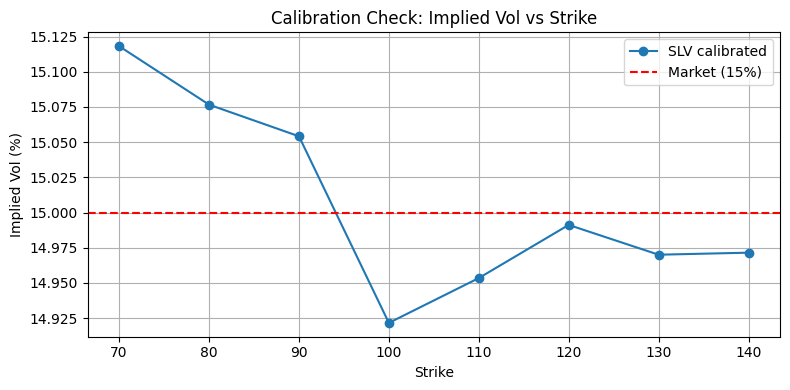

In [15]:
S_T = np.exp(logS_val)

call_prices = np.array([np.maximum(S_T - K, 0).mean() for K in K_list])
put_prices  = np.array([np.maximum(K - S_T, 0).mean() for K in K_list])

impl_vols = np.where(
    K_list < S0,
    blackscholes_impv(K_list, T, S0, put_prices, callput='put'),
    blackscholes_impv(K_list, T, S0, call_prices, callput='call')
)

print(f"{'Strike':>8s}  {'Call Price':>10s}  {'Impl Vol':>10s}")
print("-" * 34)
for K, cp, iv in zip(K_list, call_prices, impl_vols):
    print(f"{K:8.0f}  {cp:10.4f}  {iv:10.4f}")

plt.figure(figsize=(8, 4))
plt.plot(K_list, impl_vols * 100, 'o-', label='SLV calibrated')
plt.axhline(sigma_mkt * 100, color='r', linestyle='--', label='Market (15%)')
plt.xlabel('Strike')
plt.ylabel('Implied Vol (%)')
plt.title('Calibration Check: Implied Vol vs Strike')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Calibration Check.**
The implied volatilities recovered from the calibrated SLV model range between approximately 14.9% and 15.1% across all strikes, closely matching the flat market surface of $\sigma_{\text{Market}} = 15\%$. The small deviations are due to Monte Carlo noise ($N = 10{,}000$ calibration paths) and kernel regression estimation error in the tails where fewer particles are present. The calibration is successful.

# (b) Impact of Vol-of-Vol γ


In [16]:
rho_b    = 0.0
gamma_list_b = [0.0, 0.25, 0.50, 0.75]

lev_results_b = {}

for g in gamma_list_b:
    lev_store_g, _, _ = particle_method(
        S0, sigma0, Y0, rho_b, g, kappa_mr, T,
        n_steps, N_cal, sigma_mkt, kappa_bw
    )
    lev_results_b[g] = lev_store_g
    print(f"gamma = {g:.2f} done")

gamma = 0.00 done
gamma = 0.25 done
gamma = 0.50 done
gamma = 0.75 done


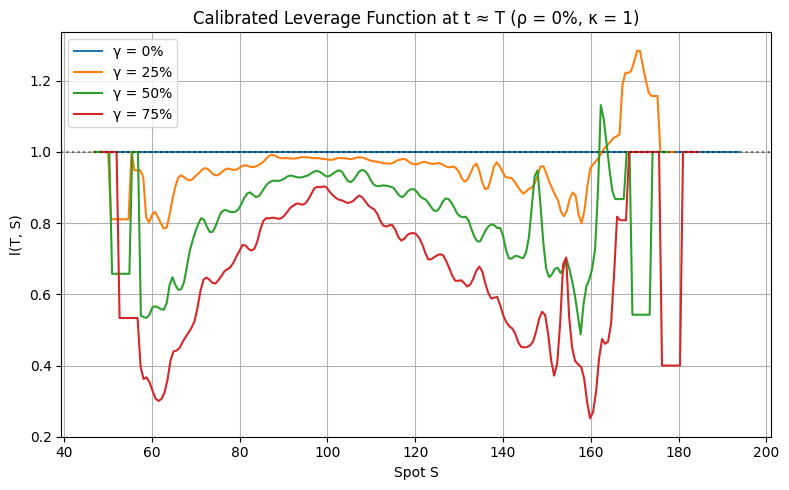

In [17]:
plt.figure(figsize=(8, 5))
for g in gamma_list_b:
    S_grid_last, lev_grid_last = lev_results_b[g][-1]
    plt.plot(S_grid_last, lev_grid_last, label=f'γ = {g:.0%}')

plt.axhline(1.0, color='k', linestyle=':', alpha=0.5)
plt.xlabel('Spot S')
plt.ylabel('l(T, S)')
plt.title('Calibrated Leverage Function at t ≈ T (ρ = 0%, κ = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Leverage function vs γ.**
When $\gamma = 0$, the leverage function is identically 1, since the model reduces to Black-Scholes and no correction is needed. As $\gamma$ increases, $l(t,S)$ deviates further from 1, dipping below 1 near ATM. This is because higher $\gamma$ causes the pure SV model to generate a larger smile, so the leverage must suppress local volatility to flatten the smile back to the market surface. The larger $\gamma$ is, the stronger the correction required.

In [18]:
def pure_sv_sim(S0, sigma0, Y0, rho_val, gamma_val, kappa_mr, T,
                n_steps, N_val, seed=123):
    dt_sim = T / n_steps
    exp_kdt = np.exp(-kappa_mr * dt_sim)
    std_Y = gamma_val * np.sqrt((1 - np.exp(-2 * kappa_mr * dt_sim)) / (2 * kappa_mr))
    rho_bar = rho_val * np.sqrt(2 * (1 - exp_kdt) / (kappa_mr * dt_sim * (1 + exp_kdt)))

    rng = np.random.default_rng(seed)
    logS = np.full(N_val, np.log(S0))
    Y = np.full(N_val, Y0)

    for k in range(n_steps):
        Y_old = Y.copy()
        Z1 = rng.standard_normal(N_val)
        Z2 = rng.standard_normal(N_val)

        Y = exp_kdt * Y_old + std_Y * Z2

        vol_eff = sigma0 * np.exp(Y_old)
        logS = (logS
                - 0.5 * vol_eff ** 2 * dt_sim
                + vol_eff * np.sqrt(dt_sim) * (np.sqrt(1 - rho_bar ** 2) * Z1
                                                + rho_bar * Z2))
    return logS

smile_sv_b = {}
for g in gamma_list_b:
    logS_sv = pure_sv_sim(S0, sigma0, Y0, rho_b, g, kappa_mr, T, n_steps, N_val)
    S_T_sv = np.exp(logS_sv)

    call_p = np.array([np.maximum(S_T_sv - K, 0).mean() for K in K_list])
    put_p  = np.array([np.maximum(K - S_T_sv, 0).mean() for K in K_list])

    iv = np.where(
        K_list < S0,
        blackscholes_impv(K_list, T, S0, put_p, callput='put'),
        blackscholes_impv(K_list, T, S0, call_p, callput='call')
    )
    smile_sv_b[g] = iv
    print(f"gamma = {g:.2f} done")

gamma = 0.00 done
gamma = 0.25 done
gamma = 0.50 done
gamma = 0.75 done


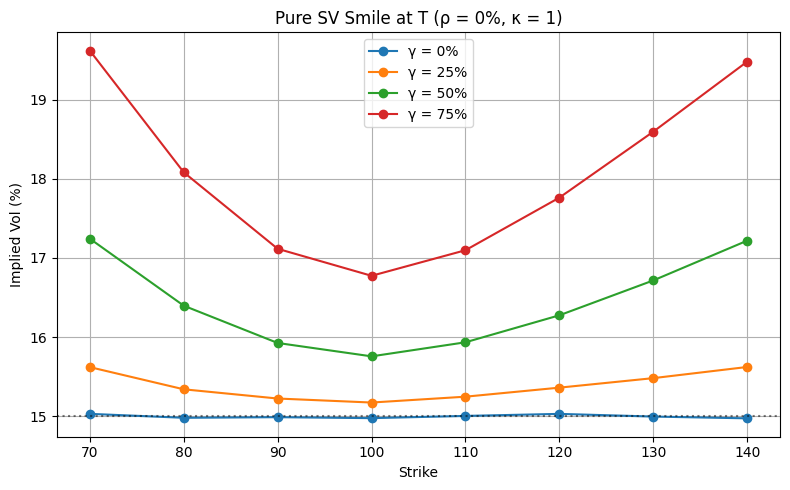

In [19]:
plt.figure(figsize=(8, 5))
for g in gamma_list_b:
    plt.plot(K_list, smile_sv_b[g] * 100, 'o-', label=f'γ = {g:.0%}')

plt.axhline(sigma_mkt * 100, color='k', linestyle=':', alpha=0.5)
plt.xlabel('Strike')
plt.ylabel('Implied Vol (%)')
plt.title('Pure SV Smile at T (ρ = 0%, κ = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Pure SV smile vs γ.**
When $\gamma = 0$, the smile is flat at 15% (Black-Scholes). As $\gamma$ increases, the smile becomes more pronounced with higher implied volatilities in the wings. Since $\rho = 0$, the smile is symmetric around ATM — there is no skew, only curvature. This confirms that $\gamma$ controls the **height and curvature** of the smile: larger vol-of-vol leads to heavier tails in the terminal distribution of $S_T$, making OTM options more expensive.

# (c) Impact of Spot-Vol Correlation ρ


In [20]:
gamma_c    = 0.50
rho_list_c = [-0.50, 0.0, 0.50]

lev_results_c = {}

for r in rho_list_c:
    lev_store_r, _, _ = particle_method(
        S0, sigma0, Y0, r, gamma_c, kappa_mr, T,
        n_steps, N_cal, sigma_mkt, kappa_bw
    )
    lev_results_c[r] = lev_store_r
    print(f"rho = {r:.2f} done")

rho = -0.50 done
rho = 0.00 done
rho = 0.50 done


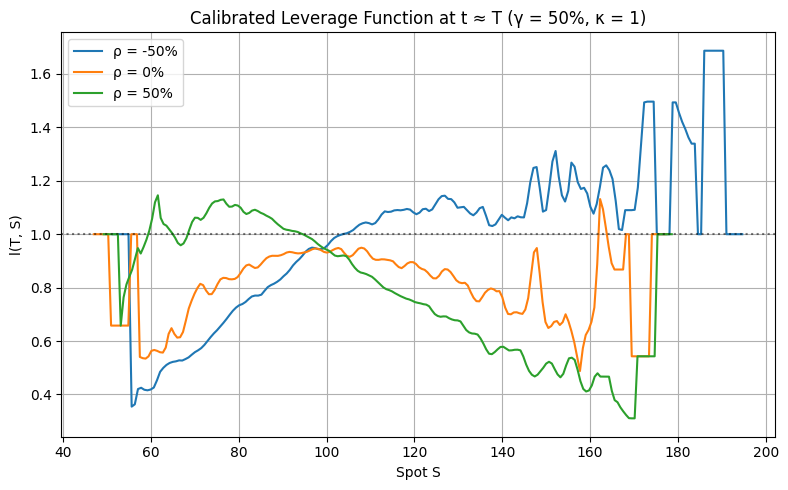

In [21]:
plt.figure(figsize=(8, 5))
for r in rho_list_c:
    S_grid_last, lev_grid_last = lev_results_c[r][-1]
    plt.plot(S_grid_last, lev_grid_last, label=f'ρ = {r:.0%}')

plt.axhline(1.0, color='k', linestyle=':', alpha=0.5)
plt.xlabel('Spot S')
plt.ylabel('l(T, S)')
plt.title('Calibrated Leverage Function at t ≈ T (γ = 50%, κ = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Leverage function vs ρ.**
The correlation $\rho$ introduces asymmetry in the leverage function. When $\rho = 0$, the leverage is roughly symmetric around ATM. When $\rho < 0$, the pure SV model produces a left skew (high vol at low strikes), so the leverage compensates by being lower at low spot values and higher at high spot values. When $\rho > 0$, the pattern reverses. In summary, $\rho$ controls the **tilt** of the leverage function.

In [22]:
smile_sv_c = {}
for r in rho_list_c:
    logS_sv = pure_sv_sim(S0, sigma0, Y0, r, gamma_c, kappa_mr, T, n_steps, N_val)
    S_T_sv = np.exp(logS_sv)

    call_p = np.array([np.maximum(S_T_sv - K, 0).mean() for K in K_list])
    put_p  = np.array([np.maximum(K - S_T_sv, 0).mean() for K in K_list])

    iv = np.where(
        K_list < S0,
        blackscholes_impv(K_list, T, S0, put_p, callput='put'),
        blackscholes_impv(K_list, T, S0, call_p, callput='call')
    )
    smile_sv_c[r] = iv
    print(f"rho = {r:.2f} done")

rho = -0.50 done
rho = 0.00 done
rho = 0.50 done


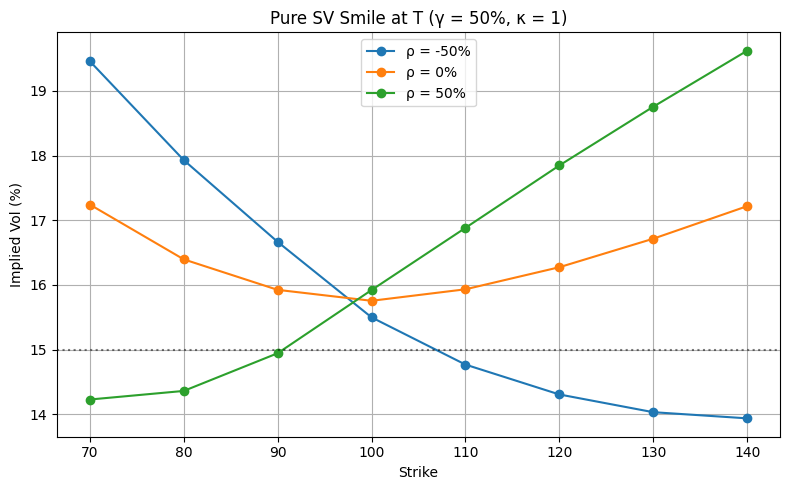

In [23]:
plt.figure(figsize=(8, 5))
for r in rho_list_c:
    plt.plot(K_list, smile_sv_c[r] * 100, 'o-', label=f'ρ = {r:.0%}')

plt.axhline(sigma_mkt * 100, color='k', linestyle=':', alpha=0.5)
plt.xlabel('Strike')
plt.ylabel('Implied Vol (%)')
plt.title('Pure SV Smile at T (γ = 50%, κ = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Pure SV smile vs ρ.**
The correlation $\rho$ determines the **skew** of the implied volatility smile. When $\rho < 0$, spot and vol move in opposite directions — a drop in spot coincides with a rise in volatility, fattening the left tail and producing a downward-sloping skew. This is consistent with the equity volatility skew observed in real markets. When $\rho > 0$, the skew reverses. When $\rho = 0$, the smile is symmetric. While $\gamma$ controls the overall curvature of the smile (as seen in part (b)), $\rho$ controls its **asymmetry**.

# (d) Impact of Mean Reversion κ

In [24]:
rho_d      = 0.0
gamma_d    = 0.50
kappa_list_d = [0.1, 1.0, 10.0]

lev_results_d = {}

for kp in kappa_list_d:
    lev_store_kp, _, _ = particle_method(
        S0, sigma0, Y0, rho_d, gamma_d, kp, T,
        n_steps, N_cal, sigma_mkt, kappa_bw
    )
    lev_results_d[kp] = lev_store_kp
    print(f"kappa = {kp:.1f} done")

kappa = 0.1 done
kappa = 1.0 done
kappa = 10.0 done


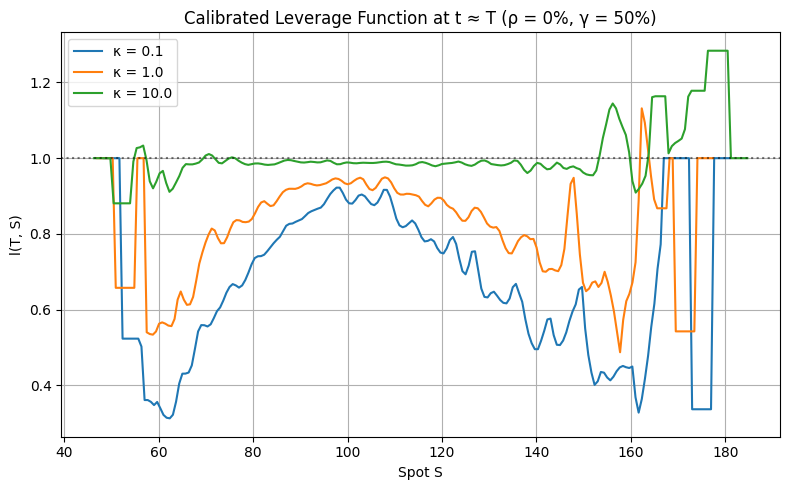

In [25]:
plt.figure(figsize=(8, 5))
for kp in kappa_list_d:
    S_grid_last, lev_grid_last = lev_results_d[kp][-1]
    plt.plot(S_grid_last, lev_grid_last, label=f'κ = {kp}')

plt.axhline(1.0, color='k', linestyle=':', alpha=0.5)
plt.xlabel('Spot S')
plt.ylabel('l(T, S)')
plt.title('Calibrated Leverage Function at t ≈ T (ρ = 0%, γ = 50%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Leverage function vs κ.**
When $\kappa = 10$, the leverage function stays close to 1, because strong mean reversion pulls $Y_t$ back to zero quickly, making the model nearly Black-Scholes. As $\kappa$ decreases, $Y_t$ can wander further from zero for longer periods, increasing the effective randomness of volatility. This produces a larger smile in the pure SV model, requiring the leverage function to deviate more from 1 to compensate. The effect of small $\kappa$ is similar to that of large $\gamma$ — both increase the realized variance of $Y_t$ — but through different mechanisms: $\gamma$ amplifies the shocks, while small $\kappa$ lets the shocks persist.

In [26]:
smile_sv_d = {}
for kp in kappa_list_d:
    logS_sv = pure_sv_sim(S0, sigma0, Y0, rho_d, gamma_d, kp, T, n_steps, N_val)
    S_T_sv = np.exp(logS_sv)

    call_p = np.array([np.maximum(S_T_sv - K, 0).mean() for K in K_list])
    put_p  = np.array([np.maximum(K - S_T_sv, 0).mean() for K in K_list])

    iv = np.where(
        K_list < S0,
        blackscholes_impv(K_list, T, S0, put_p, callput='put'),
        blackscholes_impv(K_list, T, S0, call_p, callput='call')
    )
    smile_sv_d[kp] = iv
    print(f"kappa = {kp:.1f} done")

kappa = 0.1 done
kappa = 1.0 done
kappa = 10.0 done


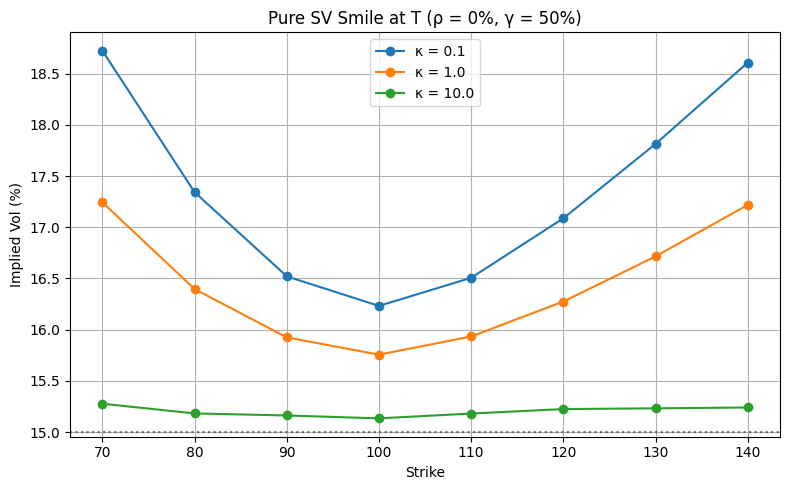

In [27]:
plt.figure(figsize=(8, 5))
for kp in kappa_list_d:
    plt.plot(K_list, smile_sv_d[kp] * 100, 'o-', label=f'κ = {kp}')

plt.axhline(sigma_mkt * 100, color='k', linestyle=':', alpha=0.5)
plt.xlabel('Strike')
plt.ylabel('Implied Vol (%)')
plt.title('Pure SV Smile at T (ρ = 0%, γ = 50%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Pure SV smile vs κ.**
When $\kappa = 0.1$, the smile is the largest because volatility mean-reverts very slowly, allowing $Y_t$ to accumulate large deviations over $[0, T]$. When $\kappa = 10$, the smile is nearly flat — volatility is effectively pinned at $\sigma_0$. Since $\rho = 0$, all three smiles are symmetric. Comparing with part (b), $\kappa$ and $\gamma$ both affect the **height** of the smile but not its asymmetry. The stationary variance of $Y_t$ is $\gamma^2 / (2\kappa)$, so increasing $\gamma$ or decreasing $\kappa$ has qualitatively the same effect on the smile.

# (e) Forward-Starting Straddle: BS vs SLV

In [28]:
gamma_e   = 1.00
rho_e     = -0.50
kappa_e   = 1.0

lev_store_e, logS_cal_e, Y_cal_e = particle_method(
    S0, sigma0, Y0, rho_e, gamma_e, kappa_e, T,
    n_steps, N_cal, sigma_mkt, kappa_bw
)

print(f"Calibration done: {len(lev_store_e)} time steps")
print(f"logS range: [{logS_cal_e.min():.2f}, {logS_cal_e.max():.2f}]")
print(f"S_T range:  [{np.exp(logS_cal_e.min()):.2f}, {np.exp(logS_cal_e.max()):.2f}]")

Calibration done: 100 time steps
logS range: [4.07, 5.19]
S_T range:  [58.46, 178.96]


In [29]:
T1_e = T - 3/12
T2_e = T
k_T1 = int(T1_e / dt)

def validation_sim_twostop(S0, sigma0, Y0, rho_val, gamma_val, kappa_mr_val, T,
                           n_steps, N_val, lev_store, k_stop, seed=123):
    dt_sim = T / n_steps
    exp_kdt = np.exp(-kappa_mr_val * dt_sim)
    std_Y = gamma_val * np.sqrt((1 - np.exp(-2 * kappa_mr_val * dt_sim)) / (2 * kappa_mr_val))
    rho_bar = rho_val * np.sqrt(2 * (1 - exp_kdt) / (kappa_mr_val * dt_sim * (1 + exp_kdt)))

    rng = np.random.default_rng(seed)
    logS = np.full(N_val, np.log(S0))
    Y = np.full(N_val, Y0)
    logS_at_stop = None

    for k in range(n_steps):
        S_grid_k, lev_grid_k = lev_store[k]
        S_particles = np.exp(logS)
        Y_old = Y.copy()

        lev_particles = np.interp(S_particles, S_grid_k, lev_grid_k)

        Z1 = rng.standard_normal(N_val)
        Z2 = rng.standard_normal(N_val)

        Y = exp_kdt * Y_old + std_Y * Z2

        vol_eff = sigma0 * np.exp(Y_old) * lev_particles
        logS = (logS
                - 0.5 * vol_eff ** 2 * dt_sim
                + vol_eff * np.sqrt(dt_sim) * (np.sqrt(1 - rho_bar ** 2) * Z1
                                                + rho_bar * Z2))

        if k + 1 == k_stop:
            logS_at_stop = logS.copy()

    return logS_at_stop, logS

logS_T1_e, logS_T2_e = validation_sim_twostop(
    S0, sigma0, Y0, rho_e, gamma_e, kappa_e, T,
    n_steps, N_val, lev_store_e, k_T1
)

print(f"k_T1 = {k_T1} (t = {k_T1 * dt:.2f})")
print(f"S_T1 range: [{np.exp(logS_T1_e.min()):.2f}, {np.exp(logS_T1_e.max()):.2f}]")
print(f"S_T2 range: [{np.exp(logS_T2_e.min()):.2f}, {np.exp(logS_T2_e.max()):.2f}]")

k_T1 = 75 (t = 0.75)
S_T1 range: [25.31, 215.05]
S_T2 range: [8.41, 298.03]


In [30]:
S_T1 = np.exp(logS_T1_e)
S_T2 = np.exp(logS_T2_e)

payoff_slv = np.abs(S_T2 / S_T1 - 1)
price_slv  = payoff_slv.mean()
se_slv     = payoff_slv.std() / np.sqrt(N_val)

tau_e = T2_e - T1_e
price_bs = blackscholes_price(1, tau_e, 1, sigma_mkt, callput='call') * 2

print(f"BS  price: {price_bs:.6f}")
print(f"SLV price: {price_slv:.6f} (SE: {se_slv:.6f})")
print(f"Ratio SLV/BS: {price_slv / price_bs:.4f}")

BS  price: 0.059827
SLV price: 0.054116 (SE: 0.000169)
Ratio SLV/BS: 0.9045


**BS vs SLV price comparison.**
Both models are calibrated to the same flat implied volatility surface of 15%, yet they produce different prices for the forward-starting straddle. The SLV model gives a lower price than Black-Scholes (ratio ≈ 0.90).

This difference arises because the forward-starting straddle depends on the **forward smile** — the distribution of volatility over the future interval $[T_1, T_2]$ — which is not determined by today's vanilla prices alone. In Black-Scholes, the forward volatility is deterministic at 15%. In the SLV model with $\rho = -50\%$, spot and vol move in opposite directions: when spot rises, vol drops and vice versa. This negative correlation partially dampens the magnitude of $S_{T_2}/S_{T_1}$, reducing the expected payoff of the straddle.

**Why use SLV models?**
This example illustrates that models calibrated to the same vanilla surface can disagree significantly on exotic prices. A pure local volatility model matches today's smile but has unrealistic forward dynamics. A pure stochastic volatility model has realistic dynamics but only approximately matches the smile. The SLV model combines both: exact calibration to vanillas via the leverage function, and realistic forward smile dynamics via the stochastic factor. This makes it the preferred framework for consistently pricing and hedging path-dependent and forward-dependent derivatives.